In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.mode.use_inf_as_na = True
matplotlib.rcParams['figure.figsize'] = (10, 7)

In [3]:
df = pd.read_csv("/content/gdrive/My Drive/ISEAR.csv", names=['#', 'emotions', 'texts'])

In [4]:
df.head()

,#,emotions,texts
0,0,joy,On days when I feel close to my partner and ot...
1,1,fear,Every time I imagine that someone I love or I ...
2,2,anger,When I had been obviously unjustly treated and...
3,3,sadness,When I think about the short time that we live...
4,4,disgust,At a gathering I found myself involuntarily si...


## Data cleaning

In [5]:
df.isna().sum()

#           0
emotions    0
texts       0
dtype: int64

In [6]:
df = df.drop(columns='#')

In [7]:
df.isna().sum()

emotions    0
texts       0
dtype: int64

In [8]:
df['emotions'].value_counts()

joy        1082
sadness    1074
anger      1069
fear       1063
disgust    1059
shame      1059
guilt      1040
Name: emotions, dtype: int64

try


In [9]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

In [10]:
df['emotions'] = encoder.fit_transform(df['emotions'])

In [11]:
df['emotions']

0       4
1       2
2       0
3       5
4       1
       ..
7441    0
7442    5
7443    1
7444    6
7445    3
Name: emotions, Length: 7446, dtype: int64

In [12]:
values = [0,1,2,3,4,5,6]
mapper = dict(zip( values, encoder.classes_))

In [13]:
mapper

{0: 'anger',
 1: 'disgust',
 2: 'fear',
 3: 'guilt',
 4: 'joy',
 5: 'sadness',
 6: 'shame'}

In [14]:
data = df[[ 'emotions', 'texts']]

In [15]:
data.head()

,emotions,texts
0,4,On days when I feel close to my partner and ot...
1,2,Every time I imagine that someone I love or I ...
2,0,When I had been obviously unjustly treated and...
3,5,When I think about the short time that we live...
4,1,At a gathering I found myself involuntarily si...



## Remove unnecessary symbols from the Phrases

In [16]:
import re
def clean_phrase(dataset):
    return re.sub("[^a-z\s']+"," ",dataset, flags=re.IGNORECASE)
data['texts'] = data['texts'].apply(clean_phrase)

In [17]:
data.shape

(7446, 2)

# Converting to lowercase

In [18]:
# converting to lower case.
data['texts'] = data['texts'].apply(lambda x: ' '.join\
                                        (x.lower() for x in x.split()))

In [19]:
data['texts'][1]

'every time i imagine that someone i love or i could contact a serious illness even death'

#Tokenization, Stopword removal and lemmatization

In [20]:
# removing symbols
#data['texts'] = data['texts'].str.replace('.', '')
#data['texts'] = data['texts'].str.replace(',', ' ')
import nltk
lemmatizer = nltk.stem.WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
from nltk.tokenize import word_tokenize

In [22]:
data['texts'] = data['texts'].apply(word_tokenize)

In [23]:
data['texts'][1]

['every',
 'time',
 'i',
 'imagine',
 'that',
 'someone',
 'i',
 'love',
 'or',
 'i',
 'could',
 'contact',
 'a',
 'serious',
 'illness',
 'even',
 'death']

In [24]:
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

In [25]:
data['texts'] = data['texts'].apply(lambda x: [token for token in x if token not in stop_words])

In [26]:
data['texts'][1]

['every',
 'time',
 'imagine',
 'someone',
 'love',
 'could',
 'contact',
 'serious',
 'illness',
 'even',
 'death']

In [27]:
data['texts'] = data['texts'].apply(lambda x: [lemmatizer.lemmatize(token, pos ="s") for token in x])

In [29]:
data['texts'] = data['texts'].apply(lambda x: ' '.join(x))

In [30]:
data['texts'][1]

'every time imagine someone love could contact serious illness even death'

In [31]:
data.head()

,emotions,texts
0,4,days feel close partner friends feel peace als...
1,2,every time imagine someone love could contact ...
2,0,obviously unjustly treated possibility elucida...
3,5,think short time live relate periods life thin...
4,1,gathering found involuntarily sitting next two...


## Visualization

In [20]:
from collections import Counter

In [21]:
labels_count=Counter(data['emotions']) #Labels count in Dataset

Text(0, 0.5, 'Number of Examples')

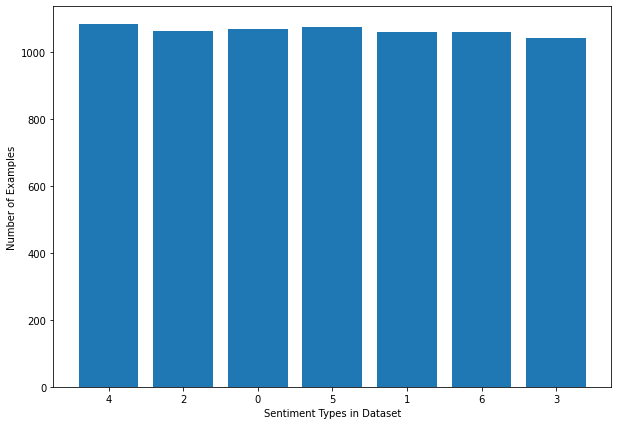

In [22]:
plt.bar(range(len(labels_count)),list(labels_count.values()),tick_label=list(labels_count.keys()))
plt.xlabel("Sentiment Types in Dataset")
plt.ylabel("Number of Examples")

# Feature Extraction

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [33]:
train_df, test_df = train_test_split(df, random_state=64, test_size=0.2)

In [34]:
X_train=train_df.texts.tolist()
y_train=train_df.emotions

X_test=test_df.texts.tolist()
y_test=test_df.emotions

In [35]:
vectorizer=TfidfVectorizer()
vectorizer.fit(X_train)
X_train_v=vectorizer.transform(X_train)
X_test_v=vectorizer.transform(X_test)

In [36]:
X_train_v.shape, y_train.shape

((5956, 7972), (5956,))

In [37]:
X_test_v.shape

(1490, 7972)

# Baseline Model

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,f1_score
from sklearn import metrics

In [45]:
grid_params = {
    'max_depth': (3, 5, 7, 9, 11, 13),
    'min_samples_split': (2, 4, 6, 8, 10)
}

In [46]:
scorer=make_scorer(f1_score,average='macro')
clf=GridSearchCV(DecisionTreeClassifier(),grid_params,scoring=scorer)
clf.fit(X_train_v,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': (3, 5, 7, 9, 11, 13),
               

In [47]:
print("The best score is: {} with params {}".format(clf.best_score_,clf.best_params_))

The best score is: 0.3311935800929654 with params {'max_depth': 13, 'min_samples_split': 6}


# Model Evaluation

In [37]:
model=DecisionTreeClassifier(random_state=1,max_depth=13,min_samples_split=2)
model.fit(X_train_v,y_train)
y_pred=model.predict(X_test_v)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.13      0.22       315
           1       0.96      0.22      0.36       322
           2       0.71      0.30      0.42       298
           3       0.85      0.18      0.30       311
           4       0.19      0.98      0.32       331
           5       0.84      0.33      0.48       331
           6       0.92      0.17      0.28       326

    accuracy                           0.33      2234
   macro avg       0.75      0.33      0.34      2234
weighted avg       0.75      0.33      0.34      2234



In [ ]:
import pickle
pickle.dump(model,open("dt_sentiment_analysis_saved_model","wb")) #save model

**Grid Search**

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
#from evolutionary_search import EvolutionaryAlgorithmSearchCV
from sklearn.metrics import make_scorer, f1_score

In [50]:
def grid_search_classifier(classifier_class, train_x,train_y,test_x,test_y,grid_params):
    print(classifier)
    scorer = make_scorer(f1_score, average = 'macro')
    clf = GridSearchCV(classifier_class(random_state=1),
                      grid_params, scoring = scorer)
    
    clf.fit(train_x,train_y)
    print(clf.best_score_, clf.best_params_)
    
    best_model = classifier_class(**clf.best_params_)
    best_model.fit(train_x, train_y)
    y_preds_final = best_model.predict(test_x)
    accuracy= f1_score(test_y,y_preds_final,average='macro')
    return accuracy

In [51]:
classifiers_to_try_out = [
    (AdaBoostClassifier,
    {'n_estimators': [20,100]}
    ),
    (DecisionTreeClassifier,
    {'max_depth': [7, 19], 'min_samples_split': [2, 4]}
    ),
    (RandomForestClassifier,
    {'n_estimators': [30],'criterion':['gini','entropy']}
    ),
    (SVC,
    {'kernel':['linear','rbf'], 'C':[1, 10]}
    ),
    (GradientBoostingClassifier,
    {'max_depth': [15, 9]})
]

In [53]:
accuracies=[]
for classifier, grid in classifiers_to_try_out:
    accuracy = grid_search_classifier(classifier, X_train_v, y_train,X_test_v,y_test, grid)
    accuracies.append({'Classifier': str(classifier),'f1_score':accuracy})
    
#print(accuracies)
classwiseaccuracy = pd.DataFrame(accuracies)

<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
0.469871236368534 {'n_estimators': 100}
<class 'sklearn.tree._classes.DecisionTreeClassifier'>
0.3826587078202464 {'max_depth': 19, 'min_samples_split': 4}
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
0.49103647786625243 {'criterion': 'gini', 'n_estimators': 30}
<class 'sklearn.svm._classes.SVC'>
0.5678301264517724 {'C': 10, 'kernel': 'rbf'}
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
0.5225317366083914 {'max_depth': 9}


In [54]:
classwiseaccuracy

,Classifier,f1_score
0,<class 'sklearn.ensemble._weight_boosting.AdaB...,0.510015
1,<class 'sklearn.tree._classes.DecisionTreeClas...,0.397658
2,<class 'sklearn.ensemble._forest.RandomForestC...,0.522185
3,<class 'sklearn.svm._classes.SVC'>,0.605022
4,<class 'sklearn.ensemble._gb.GradientBoostingC...,0.561711
